# Python packages for graph analysis

In [1]:
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

# Dataset

In [5]:
df_suggest = pd.read_csv('suggest_20.csv', encoding='euc-kr')
df_suggest.head(3)

,BILL_ID,BILL_NO,BILL_NAME,COMMITTEE,PROPOSE_DT,PROC_RESULT,AGE,DETAIL_LINK,PROPOSER,MEMBER_LIST,RST_PROPOSER,PUBL_PROPOSER,keyword,COMMITTEE_index,BILL_index
0,PRC_B1A6Z0N7H2Q6C1C0D3N0Q5K6S5U4Y2,2001183,집단소송법안,법제사법위원회,2016-07-26,임기만료폐기,20,http://likms.assembly.go.kr/bill/billDetail.do...,박영선의원 등 46인,http://likms.assembly.go.kr/bill/coactorListPo...,박영선,"강훈식,기동민,김경수,김두관,김병욱,김상희,김성수,김영주,김영춘,김종민,김종인,김현...",집단소송,0,0
1,PRC_A1B9W1O1O0B8Z1N8C4Z1M4D0E5S3J4,2023701,수산업법 일부개정법률안,농림축산식품해양수산위원회,2019-11-08,대안반영폐기,20,http://likms.assembly.go.kr/bill/billDetail.do...,박주현의원 등 10인,http://likms.assembly.go.kr/bill/coactorListPo...,박주현,"강석진,경대수,김성찬,손금주,손혜원,오영훈,윤준호,이양수,황주홍",수산업,1,1
2,PRC_G1C6M0U8R1O1O0A9C4G1S1I3M7J8J4,2001532,자동차관리법 일부개정법률안,국토교통위원회,2016-08-11,임기만료폐기,20,http://likms.assembly.go.kr/bill/billDetail.do...,임종성의원 등 11인,http://likms.assembly.go.kr/bill/coactorListPo...,임종성,"강병원,김경협,김병욱,김철민,민홍철,소병훈,안호영,윤후덕,전현희,최경환",자동차관리법,2,2


In [6]:
df_ppl = pd.read_csv('people_20.csv', encoding='euc-kr')
df_ppl.head(3)

,번호,대수,의원명,정당,소속위원회,지역,성별,당선횟수,당선방법,party_index
0,1,20,강길부,무소속,NaN,울산 울주군,남,4선,지역구,0
1,2,20,강병원,더불어민주당,NaN,서울 은평구을,남,재선,지역구,1
2,3,20,강석진,새누리당,NaN,경남 산청군함양군거창군합천군,남,초선,지역구,2


# Create an undirected graph
- nodes: 20대 국회의원
- edges: 대표 발의자 - 공동 발의자

In [7]:
from collections import defaultdict

edges = [] #edges_ = [('박영선', '강훈식'), ... ,('박영선', '최인호'), ('박주현', '강석진'), ... ,('박주현', '경대수'), ...,(대표발의자, 공동발의자)] 
edge_bill_idx = defaultdict(list) #edge_bill_idx = {('박영선', '강훈식'): [0,60], ... ,(대표발의자, 공동발의자): [입법발의안 인덱스]}

num_data = df_suggest.shape[0]
for i in range(num_data):

  rst_propersor = df_suggest.RST_PROPOSER.iloc[i] #입법발의안 대표발의자 국회의원
  publ_proposers = df_suggest.PUBL_PROPOSER.iloc[i].split(',') #입볍발의안 공동발의자 국회의원 리스트
  bill_idx = df_suggest.BILL_index.iloc[i] #입법발의안 인덱스

  for publ_proposer in publ_proposers:
    edge_ = (rst_propersor, publ_proposer)
    edges.append(edge_)
    edge_bill_idx[edge_].append(bill_idx) #동일한 대표발의자와 공동발의자가 여러번 입법발의안을 발의한 경우 존재


edge_weight = {edge_: len(bill_idx) for edge_, bill_idx in edge_bill_idx.items()} #대표발의자와 공동발의자 관계로 발의한 발의안 개수를 가중치로 사용

g =  nx.Graph(edges)

In [9]:
edges[:5] #list of edges

[('박영선', '강훈식'),
 ('박영선', '기동민'),
 ('박영선', '김경수'),
 ('박영선', '김두관'),
 ('박영선', '김병욱')]

In [ ]:
edge_bill_idx #dict of edge attribute using edge tuple as key and bill_index list as value

In [ ]:
edge_weight #dict if edge attribute(weight) using edge tuple as key and the number of bill_index as value 

In [ ]:
g.nodes

In [ ]:
g.edges

In [18]:
len(g.nodes)

318

In [19]:
len(g.edges)

11889

In [ ]:
g.degree()

## Add attributes to nodes and edges

### Node attribute (party_index)
- suggest_20.csv를 기반으로 그래프를 그리면 동명이인을 구분하지 못하므로 노드의 개수가 2개 줄어든다.
- people_20.csv를 기반으로 그래프 노드에 특성을 추가하면 노드의 개수(318)와 특성의 개수(320)가 맞지 않아 에러가 발생한다.
- 동명이인 중 한 명을 무작위로 제거하여 node와 node attribute를 맞춘다.(한계점)

In [34]:
df_ppl = df_ppl.drop_duplicates(['의원명']) #동명이인 중 한명을 무작위로 제거해서 node와 node attribute를 맞춘다(한계점)
nx.set_node_attributes(g, df_ppl.set_index('의원명')['party_index'], 'party_index')

In [31]:
list(g.nodes.data())[:10]

[('박영선', {'party_index': 1}),
 ('강훈식', {'party_index': 1}),
 ('기동민', {'party_index': 1}),
 ('김경수', {'party_index': 1}),
 ('김두관', {'party_index': 1}),
 ('김병욱', {'party_index': 1}),
 ('김상희', {'party_index': 1}),
 ('김성수', {'party_index': 1}),
 ('김영주', {'party_index': 1}),
 ('김영춘', {'party_index': 1})]

### Edge attribute(*BILL_index*)

In [32]:
#nx.set_edge_attributes(g, edge_bill_idx, 'bill_index')
nx.set_edge_attributes(g, edge_weight, 'weight')

In [33]:
list(g.edges.data())[:10]

[('박영선', '강훈식', {'weight': 2}),
 ('박영선', '기동민', {'weight': 1}),
 ('박영선', '김경수', {'weight': 1}),
 ('박영선', '김두관', {'weight': 2}),
 ('박영선', '김병욱', {'weight': 1}),
 ('박영선', '김상희', {'weight': 2}),
 ('박영선', '김성수', {'weight': 2}),
 ('박영선', '김영주', {'weight': 2}),
 ('박영선', '김영춘', {'weight': 1}),
 ('박영선', '김종민', {'weight': 3})]

# Analyze a graph

In [35]:
random_g = nx.erdos_renyi_graph(318, 0.2, directed=False)

In [36]:
len(random_g.nodes)

318

In [37]:
len(random_g.edges())

9849

<function matplotlib.pyplot.close(fig=None)>

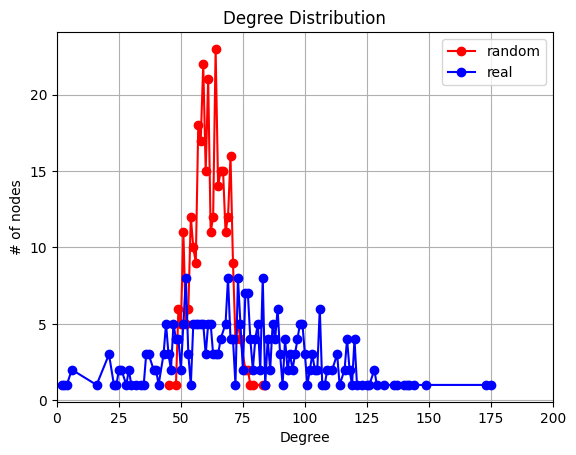

In [38]:
import matplotlib.pyplot as plt
#random graph
random_degrees = dict(random_g.degree())
random_degree_values = sorted(set(random_degrees.values()))
random_hist = [list(random_degrees.values()).count(x) for x in random_degree_values]

#real graph
degrees = dict(g.degree())
degree_values = sorted(set(degrees.values()))
hist = [list(degrees.values()).count(x) for x in degree_values]

plt.figure()
plt.grid(True) #간격표시
plt.plot(random_degree_values, random_hist, 'ro-')
plt.plot(degree_values, hist,'bo-')
plt.plot()
plt.legend(['random','real'])
plt.xlabel('Degree')
plt.ylabel('# of nodes')
plt.title('Degree Distribution')
plt.xlim([0,2*10**2])

plt.close


### clustering coefficient

In [39]:
#random graph
random_cc = dict(nx.clustering(random_g))
random_cc_values = sorted(set(random_cc.values()))
avg_random_cc = sum(random_cc.values())/len(random_cc)

#real graph
cc = dict(nx.clustering(g))
cc_values = sorted(set(cc.values()))
avg_cc = sum(cc.values())/len(cc)
print("Avg of random graph: %.3f\nAvg of real graph: %.3f"%(avg_random_cc, avg_cc))


Avg of random graph: 0.194
Avg of real graph: 0.528


### Page Rank

In [40]:
#node centrality의 상위 top개의 node를 반환
def get_top_keys(_dict_data, top):
  top_rank = sorted(_dict_data.items(), key=lambda x:x[1], reverse=True)
  return top_rank[:top]

In [41]:
pagerank = nx.pagerank(g)
pagerank_top = get_top_keys(dict(pagerank), 10)
pagerank_top

[('황주홍', 0.012813764930828645),
 ('이찬열', 0.008904489804496886),
 ('김성태', 0.008014802856531876),
 ('김도읍', 0.007995885577198316),
 ('박홍근', 0.007299286377166949),
 ('신창현', 0.006883795133562444),
 ('박정', 0.00661954785735438),
 ('이완영', 0.006170517435222764),
 ('김관영', 0.005969245229685283),
 ('서영교', 0.005938253070507875)]

### Node Centrality
- degree centrality: 연결된 node가 많을 수록 크다.
- closeness centrality: 모든 node와의 거리가 가까울수록 크다.
- betweenness centrality: 노드 간의 경로에 위치해 있을수록 크다.
- eigenvector centrality: 큰 네트워크와 연결되어 있을수록 크다.

In [42]:
 #degree centrality
 degree_centrality = nx.degree_centrality(g)
 degree_centrality_top = get_top_keys(dict(degree_centrality), 10)
 degree_centrality_top

[('박홍근', 0.5520504731861199),
 ('이철희', 0.5457413249211356),
 ('안민석', 0.4700315457413249),
 ('김성태', 0.45425867507886436),
 ('황주홍', 0.4479495268138801),
 ('서영교', 0.444794952681388),
 ('이찬열', 0.4416403785488959),
 ('박주민', 0.43217665615141954),
 ('이완영', 0.42902208201892744),
 ('노웅래', 0.41640378548895896)]

In [43]:
#closeness centrality
closeness_centrality = nx.closeness_centrality(g)
closeness_centrality_top = get_top_keys(dict(closeness_centrality), 10)
closeness_centrality_top

[('이철희', 0.6802575107296137),
 ('박홍근', 0.6788008565310493),
 ('안민석', 0.6522633744855967),
 ('황주홍', 0.6430020283975659),
 ('서영교', 0.6417004048582996),
 ('이찬열', 0.6417004048582996),
 ('김성태', 0.6404040404040404),
 ('박주민', 0.6352705410821643),
 ('이완영', 0.6327345309381237),
 ('노웅래', 0.6302186878727635)]

In [44]:
 #betweenness centrality
 betweenness_centrality = nx.betweenness_centrality(g, normalized=True)
 betweenness_centrality_top = get_top_keys(betweenness_centrality, 10)
 betweenness_centrality_top

[('황주홍', 0.01443408821977514),
 ('최인호', 0.013774154705553043),
 ('김현아', 0.013086621458916115),
 ('박홍근', 0.012291116973838235),
 ('이철희', 0.011520104243502107),
 ('김성태', 0.011421128035130528),
 ('이찬열', 0.01136141827497521),
 ('이완영', 0.010655921535207306),
 ('나경원', 0.010337628648949061),
 ('정병국', 0.009781770126644466)]

In [45]:
 #eigenvector centrality
 eigenvector_centrality = nx.eigenvector_centrality(g)
 eigenvector_centrality_top = get_top_keys(eigenvector_centrality, 10)
 eigenvector_centrality_top

[('박홍근', 0.13317967311719),
 ('이철희', 0.1314222380273776),
 ('안민석', 0.11970980260871608),
 ('서영교', 0.11275662992291673),
 ('박주민', 0.11134321155679315),
 ('박정', 0.10771201405645915),
 ('우원식', 0.10581442678314361),
 ('송옥주', 0.10538280172635694),
 ('노웅래', 0.10494080780532102),
 ('김해영', 0.10380752840454716)]

### Community
- Girvan Newman algorithm for community detection
  - Hierarhcical clustering based on edges betweenness
  - Selecting number k of communities
  - Pick k so that **modularity**(a measure of how well a network is partitioned into communitites) at k is maximized

In [46]:
from networkx.algorithms import community
comp = community.girvan_newman(g)

In [47]:
communities = tuple(sorted(c) for c in next(comp))

In [48]:
for i, comm_nodes in enumerate(communities):
  print("Community {}th".format(i))
  print(comm_nodes, end ='\n')

Community 0th
['강길부', '강병원', '강석진', '강석호', '강창일', '강효상', '강훈식', '경대수', '고용진', '곽대훈', '곽상도', '권미혁', '권석창', '권성동', '권은희', '권칠승', '금태섭', '기동민', '김경수', '김경진', '김경협', '김관영', '김광림', '김광수', '김규환', '김기선', '김도읍', '김동철', '김두관', '김명연', '김무성', '김민기', '김병관', '김병기', '김병욱', '김부겸', '김삼화', '김상훈', '김상희', '김석기', '김선동', '김성수', '김성식', '김성원', '김성찬', '김성태', '김성환', '김세연', '김수민', '김순례', '김승희', '김영우', '김영주', '김영진', '김영춘', '김영호', '김용태', '김재경', '김재원', '김정우', '김정재', '김정호', '김정훈', '김종대', '김종민', '김종석', '김종태', '김종회', '김종훈', '김중로', '김진태', '김진표', '김철민', '김태년', '김태흠', '김학용', '김한정', '김한표', '김해영', '김현권', '김현미', '김현아', '나경원', '남인순', '노웅래', '노회찬', '도종환', '맹성규', '문미옥', '문진국', '문희상', '민경욱', '민병두', '민홍철', '박경미', '박광온', '박남춘', '박대출', '박덕흠', '박맹우', '박명재', '박범계', '박병석', '박선숙', '박성중', '박순자', '박영선', '박완수', '박완주', '박용진', '박인숙', '박재호', '박정', '박주민', '박주선', '박주현', '박준영', '박지원', '박찬대', '박찬우', '박홍근', '배덕광', '백승주', '백재현', '백혜련', '변재일', '서삼석', '서영교', '서청원', '서형수', '설훈', '성일종', '소병훈', '손금주', '손혜원', '송갑석', '송기석', '송기헌', '송석준', '송언석', '송영길', 

# Draw a graph

In [49]:
nx.write_graphml_lxml(g, "assembly.graphml", infer_numeric_types=True)